In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from abtem import *

In [34]:
atoms = read('graphene.cif') * (5, 3, 1)
atoms.center(vacuum=3, axis=2)

probe = Probe(energy=80e3, semiangle_cutoff=.03, focal_spread=40, defocus=-30)
potential = Potential(atoms, sampling=.05, slice_thickness=1)

gridscan = GridScan(start=[0, 0], end=[np.sqrt(3) * 1.42, 3 * 1.42], sampling=.1)

(<matplotlib.axes._subplots.AxesSubplot at 0x131eea73c8>,
 <matplotlib.image.AxesImage at 0x131ecc69b0>)

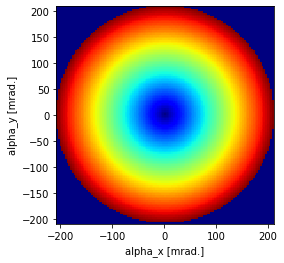

In [35]:
from abtem.detect import FlexibleAnnularDetector

detector = FlexibleAnnularDetector()

detector.show(potential.grid, probe.wavelength, cmap='jet')

In [36]:
measurements = probe.scan(gridscan, [detector], potential, max_batch=20, pbar=True)

In [37]:
measurements[detector].array.shape

(25, 43, 209)

(<matplotlib.axes._subplots.AxesSubplot at 0x131eaebba8>,
 <matplotlib.image.AxesImage at 0x131ec26ef0>)

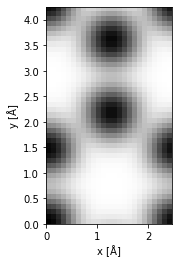

In [38]:
measurements[detector][:,:,:50].mean(-1).show()

(<matplotlib.axes._subplots.AxesSubplot at 0x131eb9eac8>,
 <matplotlib.image.AxesImage at 0x131f000e48>)

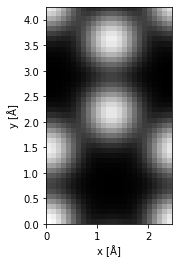

In [39]:
offset = measurements[detector].calibrations[-1].offset
sampling = measurements[detector].calibrations[-1].sampling

start = int((90 - offset) / sampling)
stop = int((200 - offset) / sampling)

measurements[detector][:,:,start:stop].mean(-1).show()

## Segmented detector

The `SegmentedDetector` is partitioned into several integration regions divided at radials and angles. This can be used for simulating for simulating differential phase contrast (DPC) imaging. 

(<matplotlib.axes._subplots.AxesSubplot at 0x131e816860>,
 <matplotlib.image.AxesImage at 0x131ecb5358>)

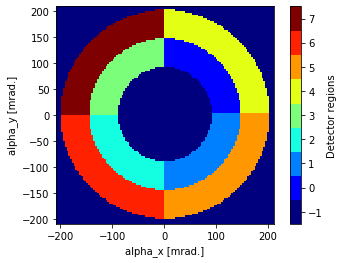

In [40]:
from abtem.detect import SegmentedDetector
dpc_detector = SegmentedDetector(inner = .09, outer=.2, nbins_radial=2, nbins_angular=4)

dpc_detector.show(potential.grid, probe.wavelength, cmap='jet', colorbar=True)

In [41]:
measurements = probe.scan(gridscan, [dpc_detector], potential, max_batch=20, pbar=True)

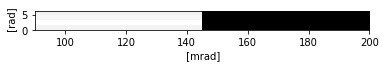

In [42]:
measurements[dpc_detector][0,1].show();

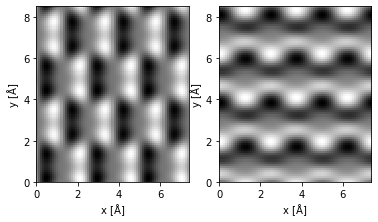

In [65]:
difference1 = measurements[dpc_detector][:, :, 0, [0,1]].mean(-1) - measurements[dpc_detector][:, :, 0,[2,3]].mean(-1)
difference2 = measurements[dpc_detector][:, :, 0, [1,2]].mean(-1) - measurements[dpc_detector][:, :, 0,[0,3]].mean(-1)

fig, (ax1, ax2) = plt.subplots(1, 2)
difference1.tile((3,2)).show(ax=ax1)
difference2.tile((3,2)).show(ax=ax2);

## Pixelated detector

The default use for `PixelatedDetector` object is to save the intensity of the fourier transformed exit wave function, i.e. a complete convergent beam electron diffraction pattern. Hence a 2D scan with this detector results in a large four-dimensional dataset (a 2D diffraction pattern recorded at every 2D probe position). The 4D datasets generated can reconstruct the results of any of the other detector geometries, hence the only downside of using this is the high memory or disk space requirement of storing the data. Optionally this can be mitigated by choosing a downscaling factor or a maximum recorded spatial frequency.

In [66]:
from abtem.detect import PixelatedDetector

pixelated_detector = PixelatedDetector()

In [69]:
measurements = probe.scan(gridscan, [pixelated_detector], potential, max_batch=200)

(<matplotlib.axes._subplots.AxesSubplot at 0x131e5bff28>,
 <matplotlib.image.AxesImage at 0x131e52c160>)

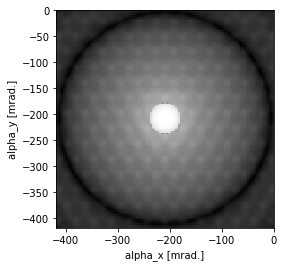

In [70]:
measurements[pixelated_detector][0,0].show(display_func=np.log)

(<matplotlib.axes._subplots.AxesSubplot at 0x131d6cdc18>,
 <matplotlib.image.AxesImage at 0x131e096ef0>)

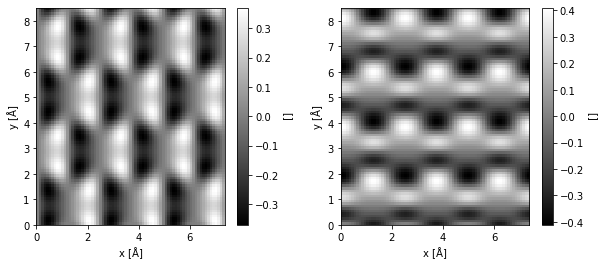

In [71]:
com_x, com_y = measurements[pixelated_detector].center_of_mass()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
com_x.tile((3,2)).show(colorbar=True, ax=ax1)
com_y.tile((3,2)).show(colorbar=True, ax=ax2)